In [1]:
import os
import numpy as np

BBO_experiments_dict = {
    "BBO 10 restarts;ShgC/DotP (baseline)": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v4_no_cache_obabel/11.03_optim_HOMO_value_baseline",
    "BBO 1 restart": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v4_no_cache_obabel/11.02_optim_HOMO_value_economic_config",
    "BBO MBTR/RBF": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v4_no_cache_obabel/11.04_optim_HOMO_value_MBTR_RBF",
    "BBO MBTR/RBF alpha 1": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v4_no_cache_obabel/11.05_optim_HOMO_value_MBTR_RBF_alpha_1"
}

EvoMol_experiments_dict = {
    "EvoMol": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v4_no_cache_obabel/11.01_EvoMol_from_methane_optim_HOMO_value",
    "EvoMol RDKit MM + cache": os.environ["DATA"] + "/07_BBO/03_bbo_optim/v3/01.01_EvoMol_from_methane_optim_HOMO_10_runs"
}

sub_experiments_names = [str(i) for i in range(1, 11)]

ECDF_TARGETS = np.arange(-10, -1, 0.01)
ERT_TARGETS = np.arange(-10, -1, 1)

In [2]:
groups = [
    (
         "All", 
         ["EvoMol", "EvoMol RDKit MM + cache", "BBO 10 restarts;ShgC/DotP (baseline)", "BBO 1 restart", "BBO MBTR/RBF", "BBO MBTR/RBF alpha 1"],
         {
         }
    ),
]


In [3]:
from bbo.postprocessing import extract_multiple_BBO_experiments_data, extract_multiple_evomol_experiments_data

def extract_all_data(BBO_experiments_dict, EvoMol_experiments_dict, sub_experiments_names):
    
    results_dict = {}
    
    for exp_name, path in BBO_experiments_dict.items():
        results_dict[exp_name] = extract_multiple_BBO_experiments_data(path, sub_experiments_names)
        
    for exp_name, path in EvoMol_experiments_dict.items():
        results_dict[exp_name] = extract_multiple_evomol_experiments_data(path, sub_experiments_names)

    return results_dict

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from bbo.evaluation import compute_ecdf

def plot_ECDF(results_dict, plot_title=None, exp_list_plot=None, exp_list_details=None, labels_dict=None):
    
    colors = sns.color_palette()
    
    plt.figure(figsize=(15, 8))
    if plot_title is not None:        
        plt.title(plot_title)
    
    plt.xlim(1, 1100)
    plt.ylim(0, 1)
    plt.xlabel("# DFT calls")
    plt.ylabel("Proportion of targets achieved")
    
    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
    
    for i, experiment_name in enumerate(exp_list_plot):
        
        if experiment_name in exp_list_plot:
            
            if labels_dict is not None and experiment_name in labels_dict:
                display_experiment_name = labels_dict[experiment_name]
            else:
                display_experiment_name = experiment_name
        
            for j in range(len(results_dict[experiment_name]["dataset_success_n_calls"])):

                if exp_list_details is not None and experiment_name in exp_list_details:
                    obj_calls, ecdf_vect = compute_ecdf(
                        obj_calls_list=[results_dict[experiment_name]["dataset_success_n_calls"][j]],
                        obj_values_list=[results_dict[experiment_name]["dataset_success_obj_value"][j]],
                        targets=ECDF_TARGETS
                    )
                    sns.lineplot(obj_calls, ecdf_vect, label=display_experiment_name, color=colors[i], 
                                 dashes=[(2, 2)], style=True)
                    plt.scatter([obj_calls[-1]], [ecdf_vect[-1]], color="black")

            obj_calls, ecdf_vect = compute_ecdf(
                obj_calls_list=results_dict[experiment_name]["dataset_success_n_calls"],
                obj_values_list=results_dict[experiment_name]["dataset_success_obj_value"],
                targets=ECDF_TARGETS
            )

            sns.lineplot(obj_calls, ecdf_vect, label=display_experiment_name, color=colors[i])
            plt.legend(loc='lower left')
        
    plt.show()

In [5]:
from bbo.evaluation import compute_ERT
import pandas as pd
from IPython.display import display, HTML

def display_ERT(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):
    
    output_keys = ["Experiment"] + [str(value) for value in ERT_TARGETS]
    ERT_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
    
    for i, experiment_name in enumerate(exp_list_plot):
        
        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
        
        ERT_vect = compute_ERT(
            obj_calls_list=results_dict[experiment_name]["dataset_success_n_calls"],
            obj_values_list=results_dict[experiment_name]["dataset_success_obj_value"],
            targets=ERT_TARGETS
        )
        
        ERT_dict["Experiment"].append(display_experiment_name)
        for j in range(len(ERT_vect)):
            ERT_dict[output_keys[j+1]].append(ERT_vect[j])
    
    df = pd.DataFrame.from_dict(ERT_dict)
    display(df)

In [6]:
import itertools

def display_stable_proportion(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):
    
    output_keys = ["Experiment", "# Stable", "# Generated", "Stable proportion (%)", "# Unique stable",
                   "# Unique generated", "Unique stable proportion (%)", "Unique stable ∩ unstable"]
    output_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())
        
    for i, experiment_name in enumerate(exp_list_plot):

        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
            
        stable_smiles = list(itertools.chain(*results_dict[experiment_name]["dataset_success_smiles"]))
        unstable_smiles = list(itertools.chain(*results_dict[experiment_name]["dataset_failed_smiles"]))
            
        stable_smiles_unique = list(np.unique(stable_smiles))
        unstable_smiles_unique = list(np.unique(unstable_smiles))
        
        intersection = np.intersect1d(stable_smiles_unique, unstable_smiles_unique)
            
        n_stable = len(stable_smiles)
        n_unstable = len(unstable_smiles)
        n_unique_stable = len(stable_smiles_unique)
        n_unique_unstable = len(unstable_smiles_unique)
        
        total_smiles = n_stable + n_unstable
        total_unique_smiles = n_unique_stable + n_unique_unstable

        stable_prop = n_stable / total_smiles * 100
        unique_stable_prop = n_unique_stable / total_unique_smiles * 100
        
        output_dict["Experiment"].append(display_experiment_name)
        
        output_dict["# Stable"].append(n_stable)
        output_dict["# Generated"].append(total_smiles)
        output_dict["Stable proportion (%)"].append(stable_prop)

        output_dict["# Unique stable"].append(n_unique_stable)
        output_dict["# Unique generated"].append(total_unique_smiles)
        output_dict["Unique stable proportion (%)"].append(unique_stable_prop)
        
        output_dict["Unique stable ∩ unstable"].append(len(intersection))
    
    df = pd.DataFrame.from_dict(output_dict)
    display(df)

In [7]:
def display_times(results_dict, plot_title=None, exp_list_plot=None, labels_dict=None):

    output_keys = ["Experiment", "Mean step time", "Mean optim. time", "Mean desc. obj. comput. time"]
    output_dict = {output_key: [] for output_key in output_keys}
    
    if plot_title is not None:
        display(HTML("<h3>" + plot_title +"</h3>"))

    if exp_list_plot is None:
        exp_list_plot = list(results_dict.keys())

    for i, experiment_name in enumerate(exp_list_plot):

        if labels_dict is not None and experiment_name in labels_dict:
            display_experiment_name = labels_dict[experiment_name]
        else:
            display_experiment_name = experiment_name
            
        if "steps_step_duration" in results_dict[experiment_name]:
            mean_step_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_step_duration"])))
            mean_optim_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_optim_duration"])))
            mean_desc_obj_time = np.mean(list(itertools.chain(*results_dict[experiment_name]["steps_desc_obj_comput_duration"])))
        else:
            mean_step_time = None
            mean_optim_time = None
            mean_desc_obj_time = None
        
        output_dict["Experiment"].append(display_experiment_name)
        output_dict["Mean step time"].append(mean_step_time)
        output_dict["Mean optim. time"].append(mean_optim_time)
        output_dict["Mean desc. obj. comput. time"].append(mean_desc_obj_time)
        
    df = pd.DataFrame.from_dict(output_dict)
    display(df)
        

In [8]:
results_dict = extract_all_data(BBO_experiments_dict, EvoMol_experiments_dict, sub_experiments_names)

# ECDF (Empirical cumulative distribution functions)

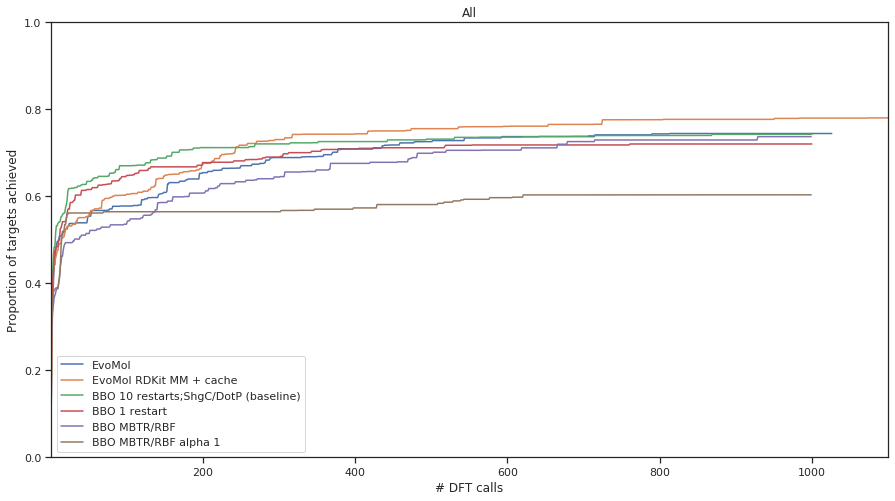

In [9]:
for group in groups:
    plot_ECDF(results_dict, group[0], group[1], labels_dict=group[2])

# ERT (Expected running time)

In [10]:
for group in groups:
    display_ERT(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  -10   -9   -8   -7    -6     -5  \
0                                EvoMol  1.9  2.1  2.9  3.7   7.2   35.8   
1               EvoMol RDKit MM + cache  1.7  2.2  2.6  3.5   6.1   34.4   
2  BBO 10 restarts;ShgC/DotP (baseline)  1.0  1.0  1.6  1.7   4.4   16.7   
3                         BBO 1 restart  1.2  1.2  1.7  2.8   7.7   32.2   
4                          BBO MBTR/RBF  1.0  1.3  1.9  2.8  23.6  113.4   
5                  BBO MBTR/RBF alpha 1  1.0  1.1  1.8  2.2  16.1   22.1   

           -4      -3   -2  
0  274.200000  3088.0  inf  
1  194.400000  1086.2  inf  
2  129.111111  3156.0  inf  
3  171.500000     inf  inf  
4  469.000000  9477.0  inf  
5         inf     inf  inf

# Times

In [11]:
for group in groups:
    display_times(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  Mean step time  Mean optim. time  \
0                                EvoMol             NaN               NaN   
1               EvoMol RDKit MM + cache             NaN               NaN   
2  BBO 10 restarts;ShgC/DotP (baseline)     1995.375571         10.491931   
3                         BBO 1 restart     3009.848622          1.984141   
4                          BBO MBTR/RBF      944.489981        276.701102   
5                  BBO MBTR/RBF alpha 1      688.886031        266.955717   

   Mean desc. obj. comput. time  
0                           NaN  
1                           NaN  
2                   1984.407129  
3                   3006.707450  
4                    663.518801  
5                    415.430721

# Proportion of stable solutions 

In [12]:
for group in groups:
    display_stable_proportion(results_dict, group[0], group[1], labels_dict=group[2])

Experiment  # Stable  # Generated  \
0                                EvoMol      4540         6654   
1               EvoMol RDKit MM + cache     22217        30478   
2  BBO 10 restarts;ShgC/DotP (baseline)      3629         7580   
3                         BBO 1 restart      3200         6750   
4                          BBO MBTR/RBF      4380        10000   
5                  BBO MBTR/RBF alpha 1      4275         7000   

   Stable proportion (%)  # Unique stable  # Unique generated  \
0              68.229636             3490                5100   
1              72.895203            10507               15108   
2              47.875989             3543                7453   
3              47.407407             3174                6720   
4              43.800000             3235                7011   
5              61.071429             2426                4037   

   Unique stable proportion (%)  Unique stable ∩ unstable  
0                     68.431373                        46  
1                     69.545936                        37  
2                     47.537904                         6  
3                     47.232143                         1  
4                     46.141777                        68  
5                     60.094129                        47

Plot évolution stabilité